Import and load data

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install neptune
!pip install neptune-tensorflow-keras
!pip install keras-cv

import neptune
from datetime import date
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_cv as tfkv
from tensorflow import keras as tfk
from keras import applications
from tensorflow.keras.applications import MobileNetV2
from keras import layers as tfkl
from tensorflow.keras import mixed_precision
from io import StringIO
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

import keras_cv


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.7 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67675 sha256=59b6aee72aff18589963f8448a6a52e1fa2253389d113aa4692ab3bc22e518ca
  Stored in directory: /root/.cache/pip/wheels/42/35/4a/44ec4c358db21a5d63ed4e40f0f0012a438106f220bce4ccba
Successfully built bravado-core
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [3]:
!cp /content/drive/MyDrive/training_set_cleaned_NODUPLICATE.npz .

data = np.load('training_set_cleaned_NODUPLICATE.npz')
X = data['images']
y = data['labels']

# Assuming 'X' and 'y' are defined from the previous code
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1:])
print("Unique labels:", np.unique(y))

Shape of X: (11951, 96, 96, 3)
Shape of y: (11951, 1)
Number of samples: 11951
Number of features: (96, 96, 3)
Unique labels: [0 1 2 3 4 5 6 7]


Example of rand augmentation

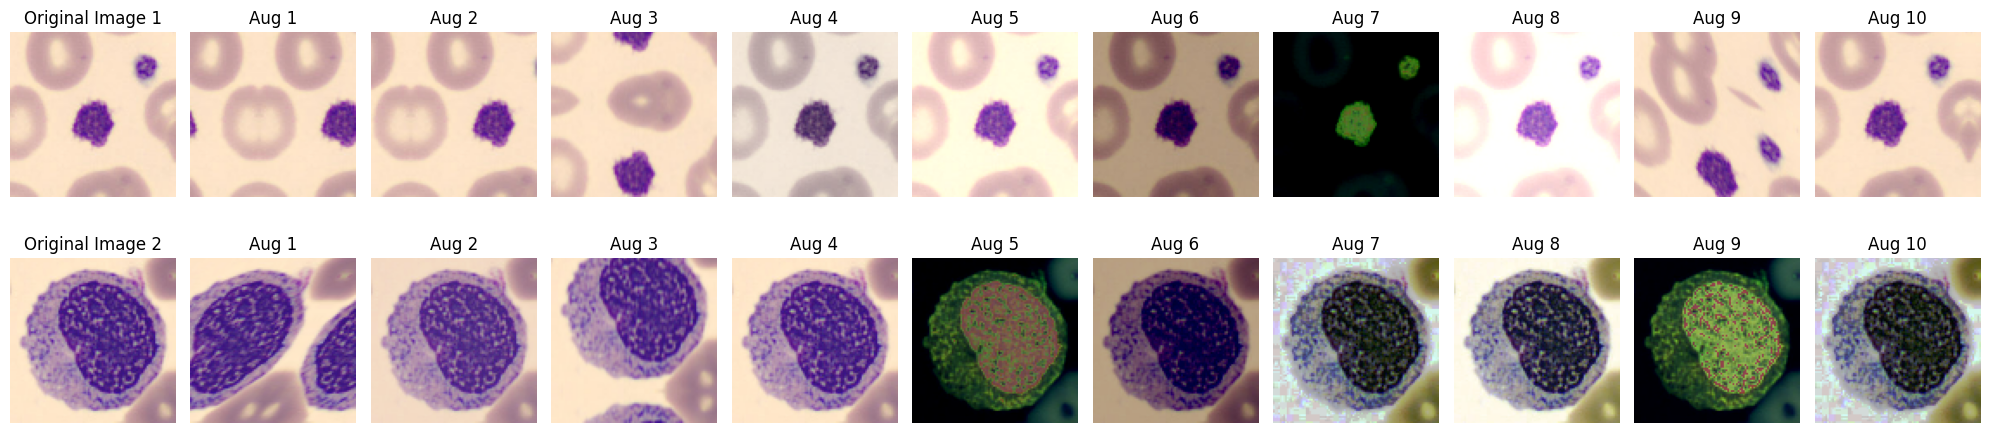

In [4]:


# Istanza di RandAugment con il numero di operazioni e l'intensità
rand_augment = keras_cv.layers.RandAugment(value_range=(0, 255), augmentations_per_image=1, magnitude=0.6)

# Selezione di due immagini dal dataset
idx1, idx2 = 0, 1  # Indici delle immagini da aumentare
image1 = X[idx1]
image2 = X[idx2]

# Preparazione delle immagini per l'augmentation
# Aggiungi una dimensione batch (1, height, width, channels) richiesta da RandAugment
image1 = tf.expand_dims(image1, axis=0)
image2 = tf.expand_dims(image2, axis=0)

# Generazione delle immagini aumentate
augmented_images1 = [rand_augment(image1)[0].numpy().astype("uint8") for _ in range(10)]
augmented_images2 = [rand_augment(image2)[0].numpy().astype("uint8") for _ in range(10)]

# Plot delle immagini originali e aumentate
fig, axes = plt.subplots(2, 11, figsize=(20, 5))

# Mostra l'immagine originale
axes[0, 0].imshow(X[idx1].astype("uint8"))
axes[0, 0].set_title("Original Image 1")
axes[0, 0].axis("off")

axes[1, 0].imshow(X[idx2].astype("uint8"))
axes[1, 0].set_title("Original Image 2")
axes[1, 0].axis("off")

# Mostra le immagini aumentate
for i in range(10):
    axes[0, i + 1].imshow(augmented_images1[i])
    axes[0, i + 1].set_title(f"Aug {i + 1}")
    axes[0, i + 1].axis("off")

    axes[1, i + 1].imshow(augmented_images2[i])
    axes[1, i + 1].set_title(f"Aug {i + 1}")
    axes[1, i + 1].axis("off")

plt.tight_layout()
plt.show()

In [5]:
# prompt: shuffle the dataaset randomly

# Shuffle the dataset randomly
combined = list(zip(X, y))
random.shuffle(combined)
X, y = zip(*combined)
X = np.array(list(X))
y = np.array(list(y))

print("Dataset shuffled.")

Dataset shuffled.


[ 850. 2179. 1085. 2023.  849.  992. 2330. 1643.]


Text(0, 0.5, 'Percentage')

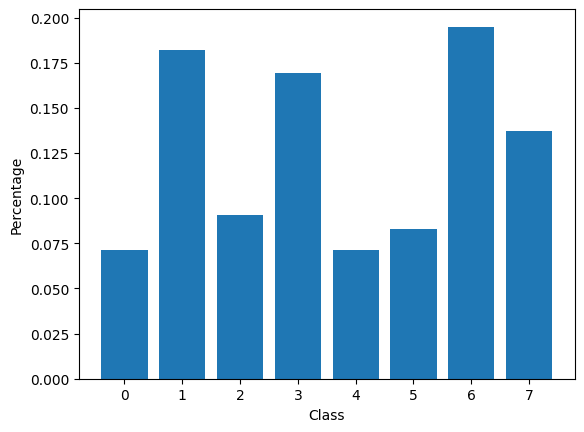

In [6]:
num_samples = np.zeros(8)

for i in range(8):
  #conto il numero di immagini con label i nel dataset
  num_samples[i] = np.sum(y == i)

print(num_samples)
#plot the percentage in the total for each class
plt.bar(range(8), num_samples/np.sum(num_samples))
plt.xlabel('Class')
plt.ylabel('Percentage')

Split data on train, validation and test

In [7]:

# Converting to one-hot encoding
seed = 42
y = tfk.utils.to_categorical(y,len(np.unique(y)))

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test)*2, stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (8363, 96, 96, 3), y_train shape: (8363, 8)
X_val shape: (2392, 96, 96, 3), y_val shape: (2392, 8)
X_test shape: (1196, 96, 96, 3), y_test shape: (1196, 8)


Show if the distributions of the sets splitted is equivalent to the original

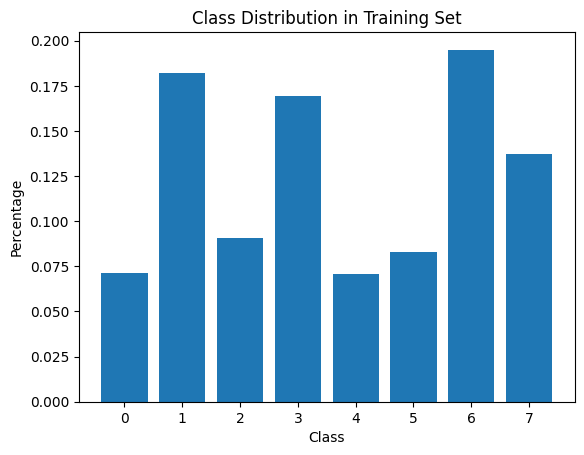

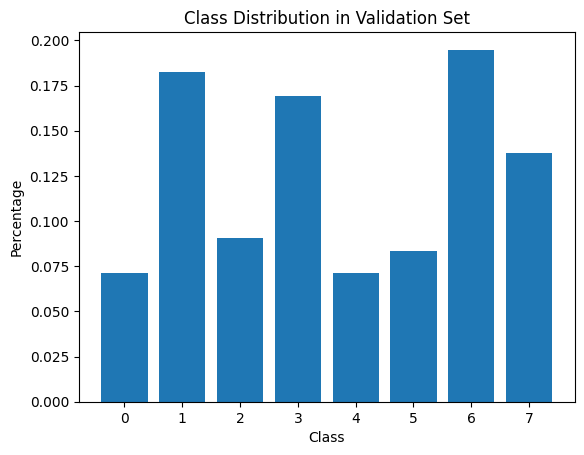

In [8]:

def plot_class_distribution(y, title):
  num_samples = np.zeros(8)
  tmp_y = np.argmax(y, axis=1)
  for i in range(8):
    num_samples[i] = np.sum(tmp_y == i)
  plt.bar(range(8), num_samples / np.sum(num_samples))
  plt.xlabel('Class')
  plt.ylabel('Percentage')
  plt.title(title)
  plt.show()

plot_class_distribution(y_train, 'Class Distribution in Training Set')
plot_class_distribution(y_val, 'Class Distribution in Validation Set')


Configuration of augmation and model

In [10]:
class DatasetConfig:
    NUM_CLASSES: int = 8
    IMG_HEIGHT:  int = 96
    IMG_WIDTH:   int = 96
    CHANNELS:    int = 3

class TrainingConfig:
    BATCH_SIZE:       int   = 32
    EPOCHS:           int   = 200
    LEARNING_RATE:    float = 0.0015
    LEARNING_DESCENT_PATIENCE: int = 5
    LEARNING_DESCENT_FACTOR: float = 0.5
    EARLY_STOPPING_PATIENCE: int = 10
    DROPOUT:          float = 0.4
    LAYERS_FINE_TUNE: int   = 0
    MODEL_NAME:       str   = "MobileNetV3_large_augment"
    RAND_AUGMENT_MAGNITUDE:     float  = 0.4
    RAND_AUGMENT_AUGMENTATIONS_PER_IMAGE: int = 2
    OPTIMIZER:        str   = "Adam"

input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)

In [11]:
 # Specify the model input shape.
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)

print('Loading model with ImageNet weights...')
MODEL_IMPORTED=tfk.applications.MobileNetV3Large(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    classes=8,
    pooling="avg",
    classifier_activation="softmax",
    include_preprocessing=True,
    name="MobileNetV3Large",
)

#print(EfficientNetV2S_conv_base.summary())


Loading model with ImageNet weights...
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


0 finetuning

In [12]:

# Set all layers in the convolutional base to Trainable (will FREEZE initial layers further below).
MODEL_IMPORTED.trainable = False

# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(MODEL_IMPORTED.layers)

print("Num_layers fine tune " + str(num_layers_fine_tune))
print("Num_layers: " + str(num_layers))

# Freeze the initial layers in the convolutional base.
for model_layer in MODEL_IMPORTED.layers[:num_layers - num_layers_fine_tune]:
    #print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False

print("\n")
print(f"Configured to fine tune the last", num_layers_fine_tune, "convolutional layers...")
print("\n")

#print(MODEL_IMPORTED.summary())

Num_layers fine tune 0
Num_layers: 188


Configured to fine tune the last 0 convolutional layers...




In [13]:
AUTO = tf.data.AUTOTUNE

rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=TrainingConfig.RAND_AUGMENT_AUGMENTATIONS_PER_IMAGE,
    magnitude=TrainingConfig.RAND_AUGMENT_MAGNITUDE

)


Create the iterator for the augmentaion

In [16]:

train_data = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(TrainingConfig.BATCH_SIZE * 100)
    .batch(TrainingConfig.BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (96, 96)), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (rand_augment(tf.cast(x, tf.uint8)), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

val_data = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(TrainingConfig.BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (96, 96)), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)


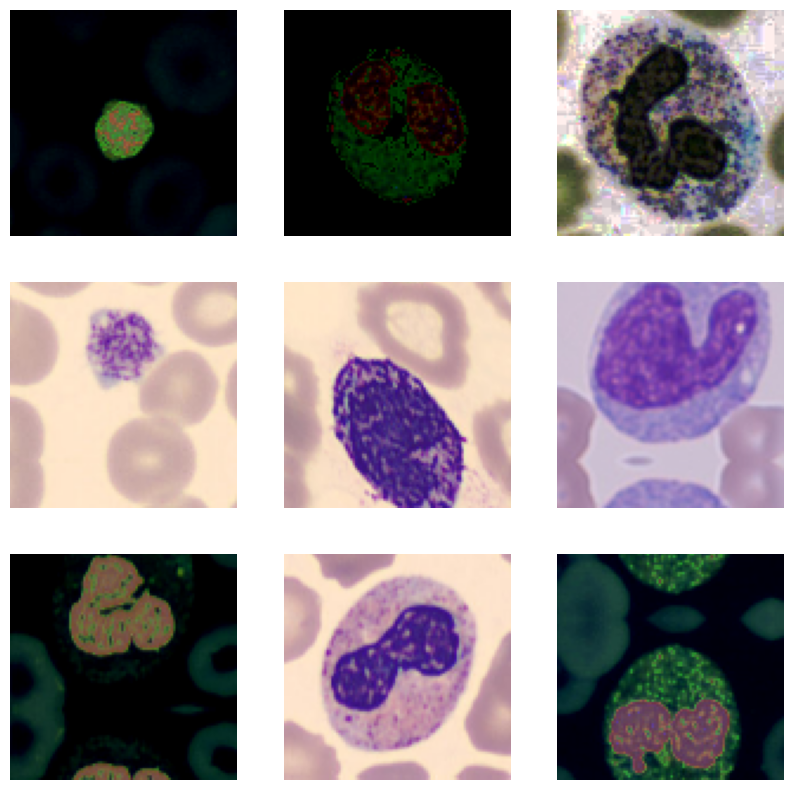

In [17]:
sample_images, _ = next(iter(train_data))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.axis("off")


In [18]:
def build_model():
  """Builds the Keras model.
  """
  inputs = tf.keras.Input(shape=input_shape)

  # Wrap the augmentation layer in a tf.function
  # Wrap augment_image in tf.py_function to execute eagerly


  x = MODEL_IMPORTED(inputs)

  x = tfkl.Dense(256, activation='relu')(x)
  x = tfkl.Dropout(TrainingConfig.DROPOUT)(x)

  x = tfkl.Dense(128, activation='relu')(x)
  x = tfkl.Dropout(TrainingConfig.DROPOUT)(x)

  outputs = tfkl.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(x)

  model = tfk.Model(inputs=inputs, outputs=outputs)
  print(model.summary())

  return model

In [19]:

model = build_model()

# Costruisci il modello

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 960)                 │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         246,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,276,296 (12.50 MB)

 Trainable params: 279,944 (1.07 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

None


Setup the training configuration and neptune

In [ ]:
!mkdir /content/drive/MyDrive/savage_model
# prompt: class neptune callback

run = neptune.init_run(
    project=f"lp1807/Homework1" , # Replace with your Neptune project
    api_token="API_TOKEN",
    name=TrainingConfig.MODEL_NAME
)



# Create a NeptuneCallback
class NeptuneCallback(tfk.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        run["model/train/accuracy"].log(logs["accuracy"])
        run["model/train/loss"].log(logs["loss"])
        run["model/val/accuracy"].log(logs["val_accuracy"])
        run["model/val/loss"].log(logs["val_loss"])


def saveNeptune_Drive():

  # Log the entire history dictionary to Neptune
  run["training/history"] = history.history  # <-- This line logs the entire training history

  for epoch in range(len(history.history['accuracy'])):
    run["training/epoch/train_accuracy"].log(history.history['accuracy'][epoch])
    run["training/epoch/val_accuracy"].log(history.history['val_accuracy'][epoch])
    run["training/epoch/train_loss"].log(history.history['loss'][epoch])
    run["training/epoch/val_loss"].log(history.history['val_loss'][epoch])

  model_summary = StringIO()
  model.summary(print_fn=lambda x: model_summary.write(x + "\n"))
  run["model/summary"] = model_summary.getvalue()

  # Log model weights and configuration
  run["model/weights"] = neptune.types.File.as_pickle(model.get_weights())
  run["model/config"] = model.get_config()

  model_file_path = f"/content/drive/MyDrive/savage_model/{TrainingConfig.MODEL_NAME}.keras"
  model.save(model_file_path)

  # Log the .keras model file to Neptune
  run["model/file"].upload(model_file_path)

  # Convert history to DataFrame and save as CSV
  history_df = pd.DataFrame(history.history)
  history_file_path = f"/content/drive/MyDrive/savage_model/{TrainingConfig.MODEL_NAME}training_history.csv"
  history_df.to_csv(history_file_path, index=False)

  # Log the CSV file to Neptune
  run["training/history_file"].upload(history_file_path)

def saveHyperparameters():
    # Salva i parametri di configurazione del dataset

    # Salva i parametri di configurazione del training
    run["config/training/batch_size"] = TrainingConfig.BATCH_SIZE
    run["config/training/epochs"] = TrainingConfig.EPOCHS
    run["config/training/learning_rate"] = TrainingConfig.LEARNING_RATE
    run["config/training/dropout"] = TrainingConfig.DROPOUT
    run["config/training/layers_fine_tune"] = TrainingConfig.LAYERS_FINE_TUNE
    run["config/training/model_name"] = TrainingConfig.MODEL_NAME
    run["config/training/learning_descent_patience"] = TrainingConfig.LEARNING_DESCENT_PATIENCE
    run["config/training/learning_descent_factor"] = TrainingConfig.LEARNING_DESCENT_FACTOR
    run["config/training/early_stopping_patience"] = TrainingConfig.EARLY_STOPPING_PATIENCE
    run["config/training/optimizer"] = TrainingConfig.OPTIMIZER
    run["config/training/rand_augment_magnitude"] = TrainingConfig.RAND_AUGMENT_MAGNITUDE
    run["config/training/rand_augment_augmentations_per_image"] = TrainingConfig.RAND_AUGMENT_AUGMENTATIONS_PER_IMAGE



mkdir: cannot create directory ‘/content/drive/MyDrive/savage_model’: File exists
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/lp1807/Homework1/e/HOM-103


In [23]:
!mkdir /content/drive/MyDrive/savage_model/checkpoints

# Define the checkpoint directory on Google Drive or locally
checkpoint_dir = '/content/drive/MyDrive/savage_model/checkpoints'  # Modify this path as needed
os.makedirs(checkpoint_dir, exist_ok=True)
saveHyperparameters()

neptune_cbk = NeptuneCallback()

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_checkpoint_epoch_{epoch:02d}.weights.h5'),
    save_weights_only=True,  # Save only model weights, not the entire model
    monitor='val_loss',      # Monitor validation loss for checkpointing
    save_best_only=True,     # Save model at the end of each epoch regardless of improvement
    save_freq = 10,                 # Save checkpoint every 5 epochs
    verbose=1                 # Print message when saving a checkpoint
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=TrainingConfig.EARLY_STOPPING_PATIENCE,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# ReduceLROnPlateau callback to decrease the learning rate when the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=TrainingConfig.LEARNING_DESCENT_FACTOR,  # Reduce the learning rate by a factor of 0.5
    patience=TrainingConfig.LEARNING_DESCENT_PATIENCE,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,  # Lower bound on the learning rate
    verbose=1  # Print out a message when learning rate is reduced
)

# Train the model with the callbacks
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=TrainingConfig.EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint_callback]  # Include both the callbacks here
)

saveNeptune_Drive()

# Finalize the Neptune run
run.stop()

Epoch 1/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 63s 184ms/step - accuracy: 0.4884 - loss: 1.4774 - val_accuracy: 0.8549 - val_loss: 0.4196 - learning_rate: 0.0015
Epoch 2/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 33s 123ms/step - accuracy: 0.7314 - loss: 0.7706 - val_accuracy: 0.8487 - val_loss: 0.3998 - learning_rate: 0.0015
Epoch 3/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - accuracy: 0.7638 - loss: 0.6821 - val_accuracy: 0.8980 - val_loss: 0.3045 - learning_rate: 0.0015
Epoch 4/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 34s 126ms/step - accuracy: 0.7673 - loss: 0.6650 - val_accuracy: 0.8959 - val_loss: 0.3083 - learning_rate: 0.0015
Epoch 5/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 40s 122ms/step - accuracy: 0.7895 - loss: 0.6115 - val_accuracy: 0.9114 - val_loss: 0.2857 - learning_rate: 0.0015
Epoch 6/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - accuracy: 0.8127 - loss: 0.5588 - val_accuracy: 0.9227 - val_loss: 0.2463 - learning_rate: 0.0015
Epoch 7/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - accura

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 278 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 278 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/lp1807/Homework1/e/HOM-103/metadata


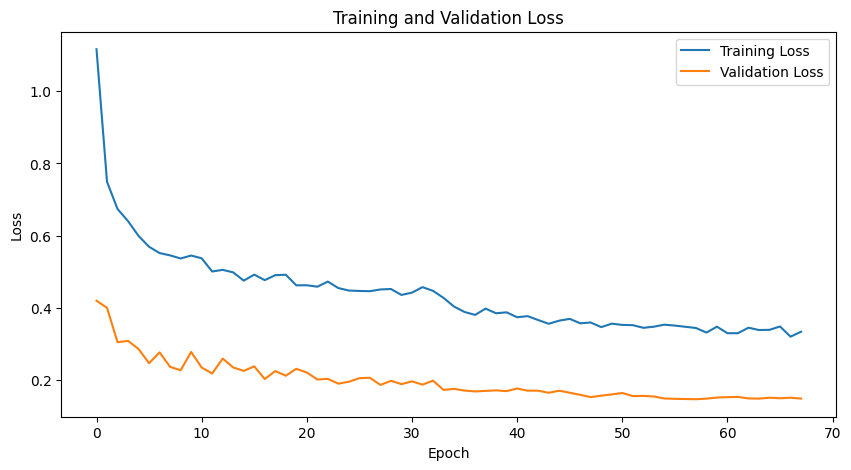

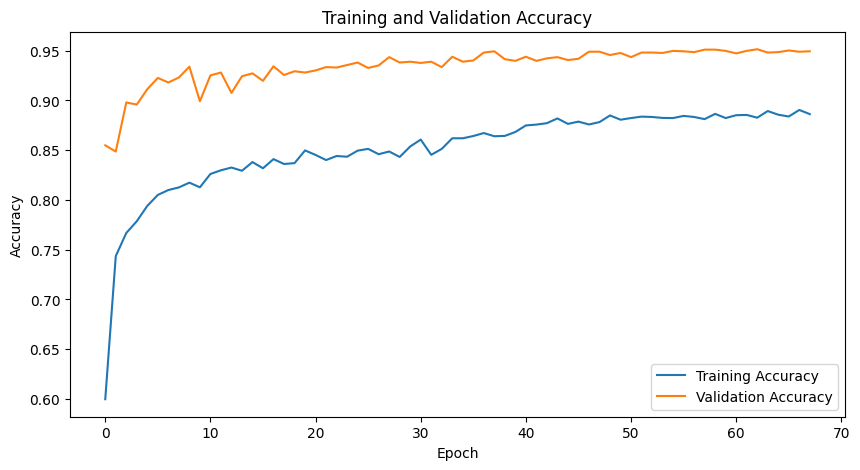

In [24]:
# prompt: plot loss and accuracy on training and validation through tranining

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Here we can see an obvious gap between validation and train loss

Test Loss: 0.1785
Test Accuracy: 0.9398
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step


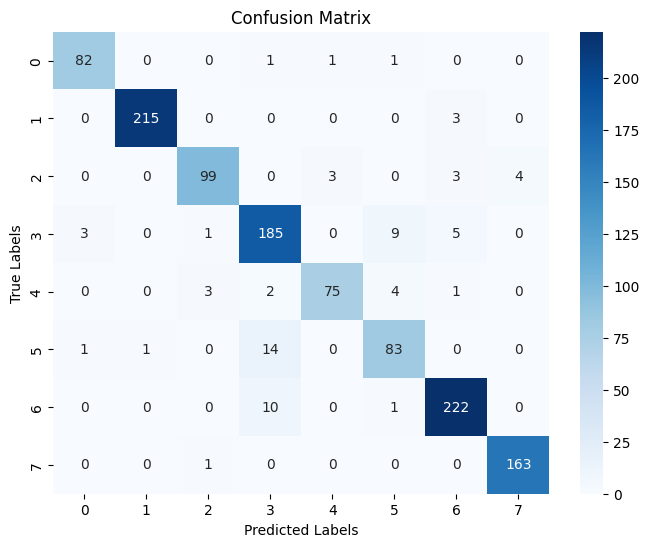

In [25]:
# prompt: testo il modello sulle immagini di test

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


# Generate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()